## Pymatgen decomposition energy
Pymatgen has code to compute the phase diagram for a composition, and use it to compute the decomposition energy
- https://pymatgen.org/pymatgen.analysis.phase_diagram.html
  - https://pymatgen.org/pymatgen.analysis.phase_diagram.html#pymatgen.analysis.phase_diagram.PhaseDiagram.get_decomp_and_e_above_hull

See how it compares to the decomposition energy from our scripts

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import os
import sys
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pymatgen import core
tqdm.pandas()

In [3]:
print(np.__version__)
print(pd.__version__)
print(core.__version__)

1.20.1
1.3.5
2022.5.26


In [5]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element

In [6]:
# Dataframe containing competing phases from NRELMatDB
# available here: https://github.com/NREL/rlmolecule/blob/devel/examples/crystal_energy/inputs/competing_phases.csv
competing_phases_file = "/projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv"
df_competing_phases = pd.read_csv(competing_phases_file)
print(f"\t{len(df_competing_phases)} lines")
df_competing_phases['energy'] = (
    df_competing_phases.energyperatom * 
    df_competing_phases.sortedformula.apply(lambda x: Composition(x).num_atoms)
)
df_competing_phases

	12682 lines


,sortedformula,icsdnum,energyperatom,reduced_composition,energy
0,Ag10Br3Te4,173116.0,-1.718985,Ag10Br3Te4,-29.222753
1,Ag11K1O16V4,391344.0,-4.797702,Ag11K1O16V4,-153.526475
2,Ag15Cl3P4S16,416586.0,-3.058555,Ag15Cl3P4S16,-116.225098
3,Ag16Ca6N1,78395.0,-1.655370,Ag16Ca6N1,-38.073520
4,Ag1Al1Li2,57330.0,-2.250116,Ag1Al1Li2,-9.000465
...,...,...,...,...,...
12677,Sn2Sr1Zn2,424108.0,-2.806786,Sn2Sr1Zn2,-14.033929
12678,Sn2Ta1,106077.0,-5.760835,Sn2Ta1,-17.282505
12679,Sn2Zr1,652857.0,-5.284548,Sn2Zr1,-15.853644
12680,Sn3Zn1Zr5,656298.0,-5.688491,Sn3Zn1Zr5,-51.196419


In [7]:
# ---FERE reference chemical potentials- ferev2_chempot
ferev2_chempot = {'Ag': -0.79, 'Al': -3.27, 'Al_anion': -3.55, 'As': -4.95, 'As_cation': -4.42, 'Au': -1.96, 'B': -6.73,
                  'B_anion': -6.44, 'Ba': -1.44, 'Be': -3.50, 'Bi_cation': -4.22, 'Bi': -4.19, 'Br': -1.54, 'C': -8.94,
                  'Ca': -1.78, 'Cd': -0.64, 'Cl': -1.74, 'Co': -4.67, 'Cr': -7.08, 'Cu': -1.87, 'F': -1.44, 'Fe': -6.00,
                  'Ga': -2.53, 'Ge': -4.34, 'Ge_anion': -4.84, 'Hf': -7.38, 'Hg': -0.10, 'I': -1.53, 'In': -2.39,
                  'Ir': -6.31, 'K': -0.79, 'La': -3.76, 'Li': -1.58, 'Mg': -1.23, 'Mo': -7.37, 'Mn': -6.86, 'N': -8.46,
                  'Na': -1.02, 'Nb': -6.92, 'Ni': -3.65, 'O': -4.80, 'P': -5.17, 'P_cation': -5.14, 'Pb': -3.85,
                  'Pb_anion': -4.29, 'Pd': -3.00, 'Pt': -3.88, 'Rb': -0.58, 'Rh': -4.66, 'Ru': -6.14, 'S': -4.01,
                  'Sb_cation': -4.13, 'Sb': -4.16, 'Sc': -4.42, 'Se': -3.54, 'Si': -5.30, 'Si_anion': -5.40,
                  'Sn': -3.87, 'Sn_anion': -3.71, 'Sr': -1.32, 'Ta': -8.82, 'Te': -3.18, 'Te_cation': -2.75,
                  'Ti': -5.39, 'V': -6.40, 'W': -9.61, 'Y': -4.96, 'Zn': -0.94, 'Zr': -6.39}
fere_entries = [PDEntry(e, energy) for e, energy in ferev2_chempot.items() if "ion" not in e]

In [8]:
pd_entries = df_competing_phases.progress_apply(
    lambda row: PDEntry(Composition(row.sortedformula),
                        row.energy), 
    axis=1
)

  0%|          | 0/12682 [00:00<?, ?it/s]

In [9]:
pd_entries = pd.concat([pd.Series(fere_entries), pd_entries]).reset_index()[0]
pd_entries

0                 PDEntry : Ag1 with energy = -0.7900
1                 PDEntry : Al1 with energy = -3.2700
2                 PDEntry : As1 with energy = -4.9500
3                 PDEntry : Au1 with energy = -1.9600
4                  PDEntry : B1 with energy = -6.7300
                             ...                     
12735    PDEntry : Sn2 Sr1 Zn2 with energy = -14.0339
12736        PDEntry : Sn2 Ta1 with energy = -17.2825
12737        PDEntry : Sn2 Zr1 with energy = -15.8536
12738    PDEntry : Sn3 Zn1 Zr5 with energy = -51.1964
12739         PDEntry : Li2 O1 with energy = -14.3010
Name: 0, Length: 12740, dtype: object

In [10]:
len(pd_entries)

12740

In [11]:
set(pd_entries[0].composition.elements)

{Element Ag}

### Compute the decomposition energy for many structures

In [12]:
df = pd.read_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa-no-halides-ScY/viz/pred_vs_dft_corrected.csv", index_col=0)
df.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1,0.00926,-4.608471,0.036789
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2,0.04500,-2.620724,0.244000


In [14]:
def compute_pymatgen_decomp_energy(row):
    comp = Composition(row.comp)
    
    energy = row.energyperatom * comp.num_atoms
    
    entry = PDEntry(comp, energy)
    elements = set(comp.elements)
    curr_entries = [e for e in pd_entries \
                    if len(set(e.composition.elements) - elements) == 0]
    
    # adding the current composition to the phase diagram doesn't make a difference
    # srt_comp = sort_comp(str_comp)[0]
    # if srt_comp not in df_competing_phases.reduced_composition.values:
        # curr_entries += [entry]
    # print(f"{len(curr_entries)} entries match an element")
    phase_diagram = PhaseDiagram(curr_entries, elements=elements)
    decomp, decomp_energy = phase_diagram.get_decomp_and_e_above_hull(entry, allow_negative=True)
    
    return decomp_energy

In [15]:
df2 = df.copy()
df2.loc[:, 'pymatgen_decomp_energy'] = df2.progress_apply(compute_pymatgen_decomp_energy, axis=1)

  0%|          | 0/381 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='decomp_energy', ylabel='pymatgen_decomp_energy'>

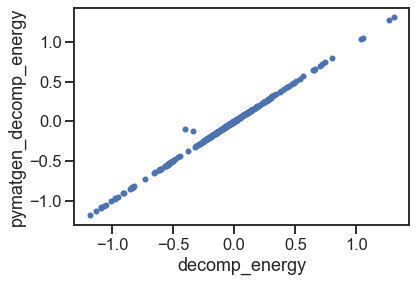

In [16]:
df2.plot.scatter(x='decomp_energy', y='pymatgen_decomp_energy')

In [22]:
df2['decomp_err'] = (df2.pymatgen_decomp_energy - df2.decomp_energy).abs()

In [24]:
df2.sort_values(by='decomp_err', ascending=False).head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,pymatgen_decomp_energy,decomp_err
73,Li1Zn1P1/Li1Zn1P1_sg186_icsd_603171_3,24,374.30,-3.357,Li1Zn1P1,Li1Zn1P1_sg186_icsd_603171_3,-0.402662,-3.302149,-0.347811,-0.094243,0.308420
320,Li1Cd1P1/Li1Cd1P1_sg216_icsd_161714_4,12,230.09,-3.201,Li1Cd1P1,Li1Cd1P1_sg216_icsd_161714_4,-0.340978,-3.103680,-0.243658,-0.129075,0.211903
